# Retrieval Optimizer | Getting Started

This notebook will walk through how to get going optimizing your vector retrieval.

## 1 - creating a dataset

For the retrieval optimization framework to run it requires a set of raw chunks and a set of queries with labeled chunks. The labeling tool can be used to generate these artifacts from an existing index or they can be created manually. See [README.md](../../README.md) for more information or checkout [process_data.ipynb](./process_data.ipynb).

For this demo, examples have been provided in the [data/](./data) directory. Let's see what they look like:

In [1]:
import json

with open("data/mazda_chunks.json", "r") as f:
    chunks = json.load(f)

chunks[0]

{'item_id': '119',
 'text': 'qMirror Defrosterí To turn on the mirror defrosters, turn the ignition switch to the ON position and push the rear window defroster switch (page 5-58).\n\nForm No.8Y64-EA-08A\n\nBlack plate (181,1)\n\nDriving Your Mazda Switches and Controls\n\nHorn\n\nTo sound the horn, press the the steering wheel.\n\nmark on\n\níSome models.\n\n5-59\n\nMazda3_8Y64-EA-08A_Edition1 Page182 Tuesday, November 27 2007 9:1 AM\n\nDriving Your Mazda Switches and Controls\n\nHazard Warning Flasher\n\nThe hazard warning lights should always be used when you stop on or near a roadway in an emergency.\n\nThe hazard warning lights warn other drivers that your vehicle is a traffic hazard and that they must take extreme caution when near it.\n\nHazard warning flasher\n\nDepress the hazard warning flasher and all the turn signals will flash.\n\nNOTE l The turn signals do not work when the\n\nhazard warning lights are on.\n\nl Check local regulations about the use of\n\nhazard warning li

In [2]:
with open("data/mazda_labeled.json", "r") as f:
    labeled = json.load(f)

labeled[0]

{'query': 'At what speed should I shift from 2 to 3 with a manual transmission?',
 'relevant_item_ids': ['86']}

#### Notes on the data

These jsons were generated using the labeling tool (see readme) however to run a study all you need to provide is a set of chunks of the form:

```json
[
    {
        "item_id": "chunk:123",
        "text": "raw content of the chunk"
    }
]
```

And a set of labeled queries:

```json
[
    {
        "query": "relevant question?",
        "relevant_item_ids": ["chunk:123"] // list of the relevant chunks to that question
    }
]
```

## 2 - python dependencies & env setup

This project utilizes poetry for dependency management. If you like, in the project root you can run `poetry install` then set the kernel version of this notebook to point to the path of the python interpreter poetry is referencing. This can be accomplish by running `poetry env info --path` after installing and setting as your kernel for the notebook.

Alternatively you can run the following line to import in a notebook native way for convenience.

In [3]:
%pip install numpy redisvl sentence-transformers redis optuna pandas nest-asyncio


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Important!

The following code allows for us to run async functions in jupyter and adds the optimize module to path for easy import.

In [3]:
import sys
import os

# Add the parent directory to the Python path to get optimize module
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..')))

import nest_asyncio

# Apply the nest_asyncio patch: let's us run async code in Jupyter
nest_asyncio.apply()

## 3 - defining a study config

Under the hood, this framework is performing bayesian optimization utilizing the optuna library. This process determines the set of decision variables that best optimize the cost function. It accomplishes this by trying different combinations of the decision variables and intelligently traversing the solution space in the direction of best results.

At current the available decision variables are:

- algorithm ("hnsw" or "flat")
  - if hnsw secondary hyper-parameters of ef_runtime, ef_construction, and m can also be optimized.
- vector data type
- ret k
- embedding model

Different configurations of these variables will be attempted in order to **maximize** the following equation: `obj = w0 * f1 + w1 * norm_embedding_latency + w2 * norm_indexing_time` expressed in vector notation this is the dot product of `weights * metrics`. If there are additional metrics you would like to optimize over feel free to open an issue and we can look into adding it!

#### study_config.yaml
```yaml
input_data_type: "json" # currently only json but considering alternatives
raw_data_path: "data/mazda_chunks.json" # path to data files for easy read
labeled_data_path: "data/mazda_labeled.json" # labeled data

# optimization config
n_trials: 20
n_jobs: 1

# metrics to be used in objective function
metrics: ["f1_at_k", "embedding_latency", "total_indexing_time"] 
weights: [1, 1, 1] # weight of each metric respectively 

# optimization decision variables
algorithms: ["flat", "hnsw"] # indexing algorithms variables
vector_data_types: ["float32", "float16"] # vector type of indexed vectors
ret_k: [1, 10] # potential range of value to be sampled during study

# ef_runtime, ef_construction, and m only relevant if HNSW indexing
ef_runtime: [10, 20, 30, 50]
ef_construction: [100, 150, 200, 250, 300]
m: [8, 16, 64]

# embedding models to be used
embedding_models:
  - provider: "hf"
    model: "sentence-transformers/all-MiniLM-L6-v2"
    dim: 384
  - provider: "hf"
    model: "intfloat/e5-large-v2"
    dim: 1024
```

#### Load the study config


In [4]:
from optimize.study import load_config

study_config = load_config("study_config.yaml") # Loads yaml into pydantic model

study_config.embedding_models[1]

EmbeddingModel(provider='hf', model='intfloat/e5-large-v2', dim=1024)

# 4 - running a redis instance

For the following code to work we need to have a running instance of redis. 

The easiest way to do this is with docker:

`docker run -d --name redis -p 6379:6379 -p 8001:8001 redis/redis-stack:latest`

#### Note: running redis-stack will expose a GUI (Redis Insight) for interacting with your data on port 8001

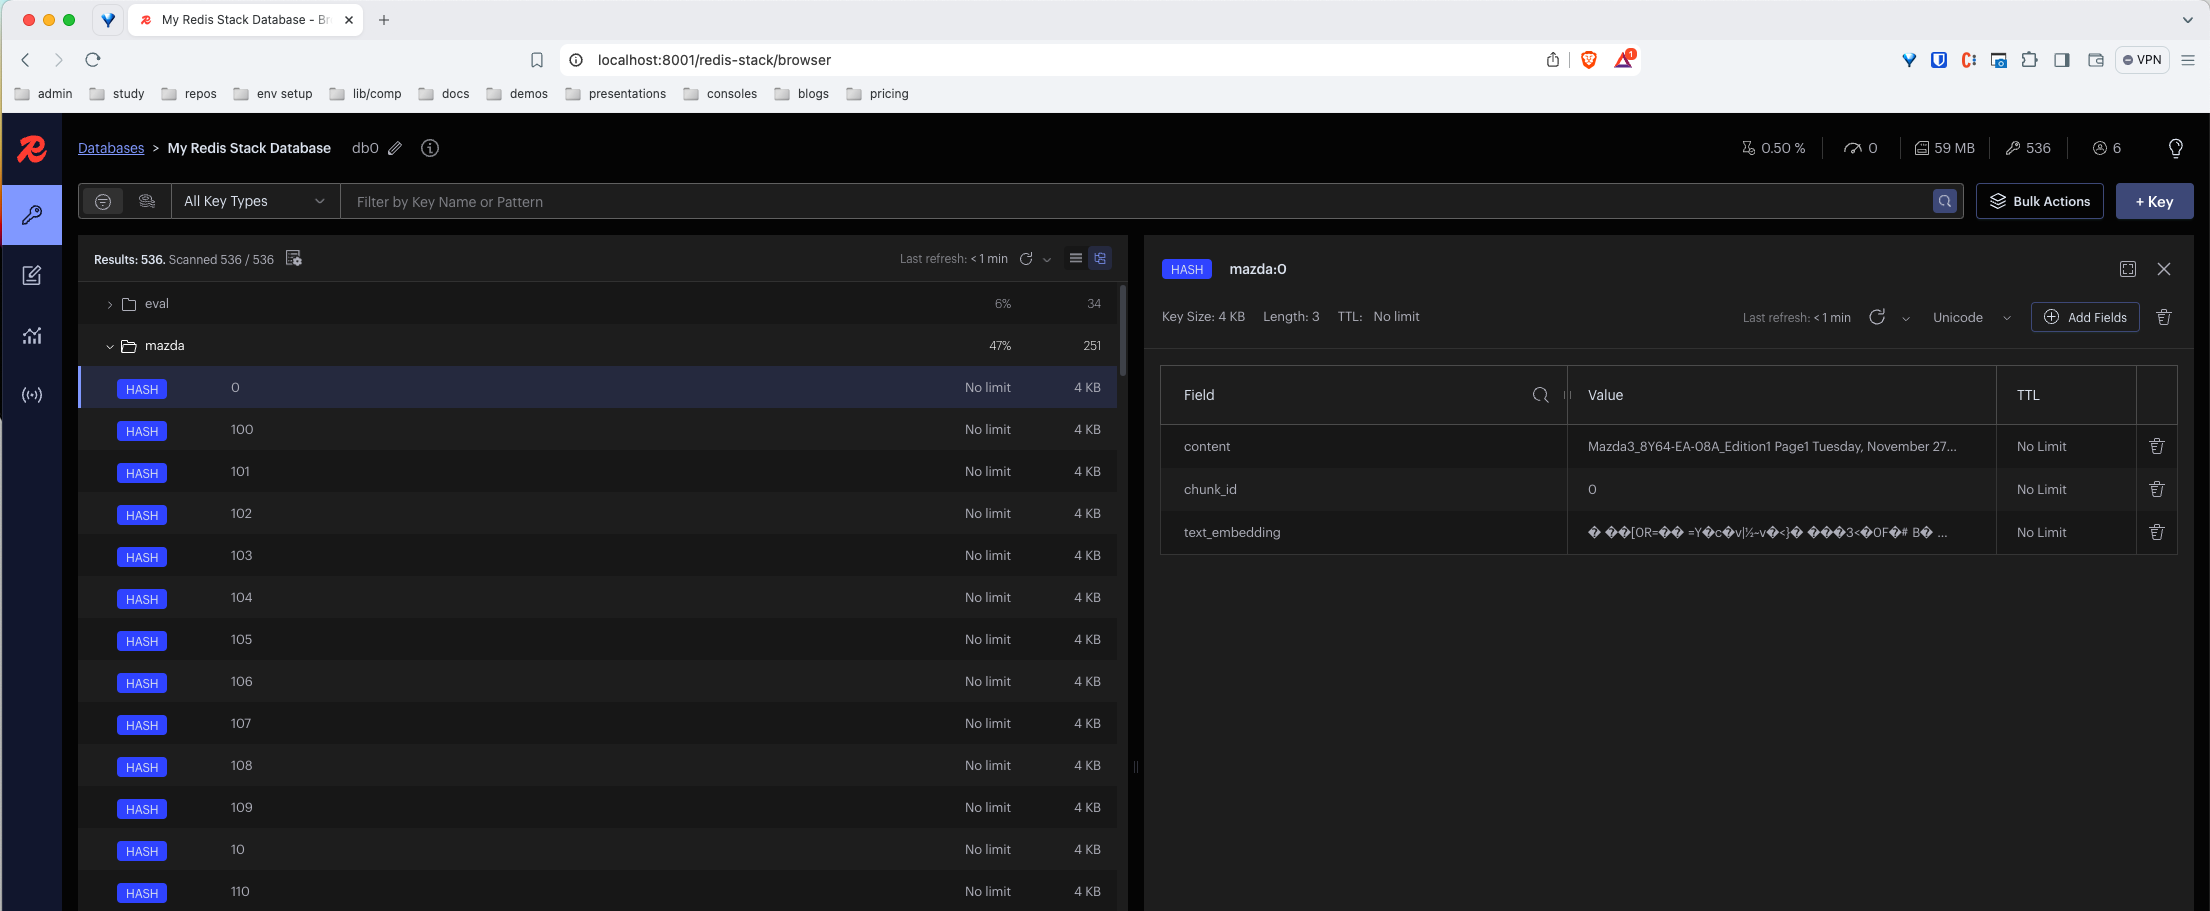

# 5 - understanding the eval class

The optimization works by instantiating different variation of the eval class and running calc metrics. Let's run an evaluation to get a baseline for our study.

In [5]:

# list of stopwords to filter out noise from query string
stopwords = set([
    "a", "is", "the", "an", "and", "are", "as", "at", "be", "but", "by", "for",
    "if", "in", "into", "it", "no", "not", "of", "on", "or", "such", "that", "their",
    "then", "there", "these", "they", "this", "to", "was", "will", "with"
])

def tokenize_query(user_query: str) -> str:
    """Convert a raw user query to a redis full text query joined by ORs"""
    tokens = [token.strip().strip(",").lower() for token in user_query.split()]
    return " | ".join([token for token in tokens if token not in stopwords])

# Example
tokenize_query(labeled[0]["query"])

'what | speed | should | i | shift | from | 2 | 3 | manual | transmission?'

In [ ]:
from optimize.eval import Eval
from redisvl.query import VectorQuery
from redisvl.utils.vectorize import BaseVectorizer

from redisvl.query.filter import Text

def custom_vector_query(user_query: str, emb_model: BaseVectorizer, k: int, dtype: str):
    base_full_text_query = str(Text("text") % tokenize_query(user_query))
    base_filter = f"(~{base_full_text_query})"

    query = VectorQuery(
        vector=emb_model.embed(user_query, as_buffer=True, dtype=dtype),
        vector_field_name="vector",
        return_score=True,
        return_fields=["item_id"],
        num_results=k,
    )

    query.set_filter(base_filter)

    print(f"Running: {query.query_string()} \n")

    return query


e = Eval(
    model_provider="hf",
    model_str="intfloat/e5-large-v2",
    embedding_dim=1024,
    raw_data_path=study_config.raw_data_path,
    labeled_data_path=study_config.labeled_data_path,
    input_data_type=study_config.input_data_type,
    vector_data_type=study_config.vector_data_types[0],
    algorithm=study_config.algorithms[0],
    ret_k=4,
    find_threshold=False,
    vector_query=custom_vector_query,
)

2024-11-20 13:51:20,100 - INFO - Load pretrained SentenceTransformer: intfloat/e5-large-v2
2024-11-20 13:51:22,390 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

2024-11-20 13:51:38,003 - INFO - Indexing data...
2024-11-20 13:51:38,531 - INFO - Data indexed. self.total_indexing_time=99.4520034790039s


## What just happened?

1. eval class embedded the chunks with the specified model
2. created a search index in redis
3. loaded the chunks into the index

#### Now let's calculate some metrics!

In [7]:
e.calc_metrics()

2024-11-20 13:51:44,245 - INFO - Load pretrained SentenceTransformer: intfloat/e5-large-v2
2024-11-20 13:51:45,444 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-11-20 13:51:46,730 - INFO - Calculating retrieval metrics for test_id: 5c449be3-2a35-4a2a-8a3e-8d4d6396106e
2024-11-20 13:51:46,735 - INFO - Overall f1 at 4 for retrieval: 0.5003968253968254


In [ ]:
raise Exception("Stop here")

#### What just happened?

- the queries provided in the label section were run against the index and the result recorded
- precision, recall, and f1 @k were calculated for the configuration
- results and metadata of the eval was persisted to redis

For each test a UUID is created and information stored in redis. The following shows the test_id and the overall f1 score

In [8]:
e.settings.test_id, e.f1_at_k, e.avg_query_latency

('201d0ddd-faff-4886-83b0-f0865cd63f1b',
 0.5003968253968254,
 0.01651666561762492)

Going back to redis insight you can see the full results of this test and the distance samples

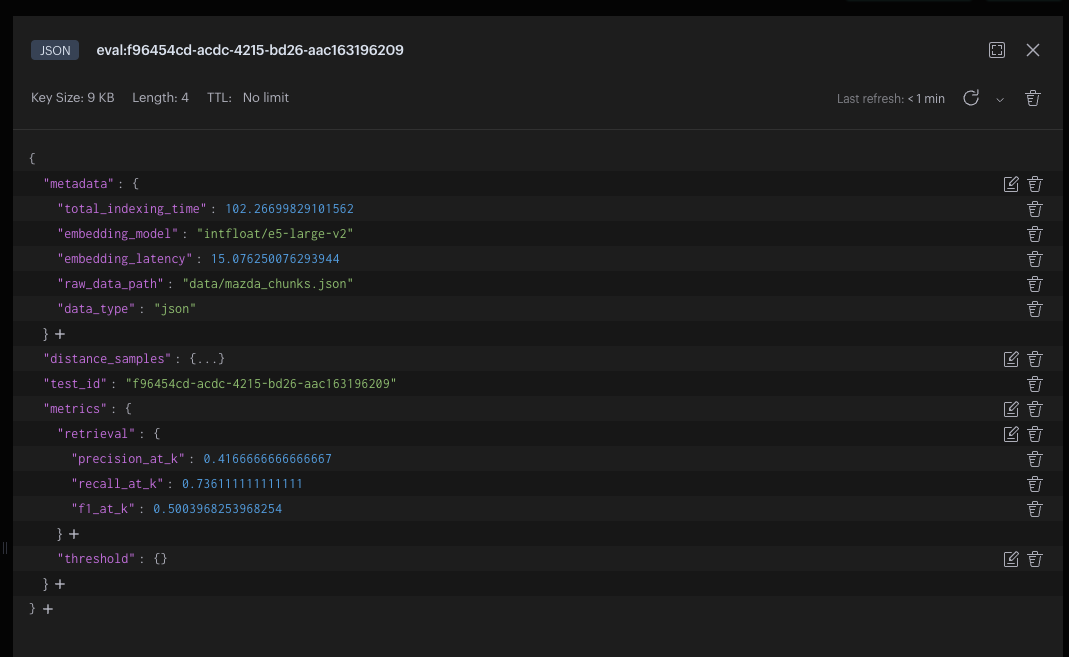

# 6 - running an optimization

Now that we understand the components let's run a study.

In [9]:
from optimize.study import run_study

run_study(study_config)

[I 2024-11-20 13:20:39,497] A new study created in memory with name: test
2024-11-20 13:20:39,514 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2




 Running for: 
 model_str: sentence-transformers/all-MiniLM-L6-v2 
 ef_runtime: 30 
 ef_construction: 200 
 m: 8 




2024-11-20 13:20:40,201 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

2024-11-20 13:20:41,079 - INFO - Indexing data...
2024-11-20 13:20:41,248 - INFO - Data indexed. self.total_indexing_time=130.18299865722656s
2024-11-20 13:20:41,256 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-20 13:20:41,903 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-11-20 13:20:42,551 - INFO - Calculating retrieval metrics for test_id: 80b825a8-3b03-478c-a99b-0fc497783d1a
2024-11-20 13:20:42,557 - INFO - Overall f1 at 3 for retrieval: 0.6603174603174603
[I 2024-11-20 13:20:42,559] Trial 0 finished with value: 1.241967409229769 and parameters: {'model_info': {'provider': 'hf', 'model': 'sentence-transformers/all-MiniLM-L6-v2', 'dim': 384}, 'algorithm': 'hnsw', 'var_dtype': 'float32', 'ret_k': 3, 'ef_runtime': 30, 'ef_construction': 200, 'm': 8}. Best is trial 0 with value: 1.241967409229769.
2024-11-20 13:20:42,570 - INFO - Load pretrained SentenceTransformer: intfloat/e5-large-v2




 Running for: 
 model_str: intfloat/e5-large-v2 
 algorithm: flat


2024-11-20 13:20:43,727 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

2024-11-20 13:20:59,127 - INFO - Indexing data...
2024-11-20 13:20:59,397 - INFO - Data indexed. self.total_indexing_time=102.25199890136719s
2024-11-20 13:20:59,407 - INFO - Load pretrained SentenceTransformer: intfloat/e5-large-v2
2024-11-20 13:21:00,503 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-11-20 13:21:01,442 - INFO - Calculating retrieval metrics for test_id: 0dbf1067-a467-4caf-bd1a-2095f9ccacb1
2024-11-20 13:21:01,447 - INFO - Overall f1 at 5 for retrieval: 0.4719215969215969
[I 2024-11-20 13:21:01,449] Trial 1 finished with value: 0.5437941039214151 and parameters: {'model_info': {'provider': 'hf', 'model': 'intfloat/e5-large-v2', 'dim': 1024}, 'algorithm': 'flat', 'var_dtype': 'float32', 'ret_k': 5}. Best is trial 0 with value: 1.241967409229769.
2024-11-20 13:21:01,457 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2




 Running for: 
 model_str: sentence-transformers/all-MiniLM-L6-v2 
 algorithm: flat


2024-11-20 13:21:02,184 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

2024-11-20 13:21:02,963 - INFO - Indexing data...
2024-11-20 13:21:03,126 - INFO - Data indexed. self.total_indexing_time=79.89399719238281s
2024-11-20 13:21:03,135 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-20 13:21:03,672 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-11-20 13:21:04,102 - INFO - Calculating retrieval metrics for test_id: f581db8e-e09d-42e0-8a66-64c9a3d0422b
2024-11-20 13:21:04,108 - INFO - Overall f1 at 7 for retrieval: 0.4884550634550635
[I 2024-11-20 13:21:04,109] Trial 2 finished with value: 1.0929336702113144 and parameters: {'model_info': {'provider': 'hf', 'model': 'sentence-transformers/all-MiniLM-L6-v2', 'dim': 384}, 'algorithm': 'flat', 'var_dtype': 'float16', 'ret_k': 7}. Best is trial 0 with value: 1.241967409229769.
2024-11-20 13:21:04,116 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2




 Running for: 
 model_str: sentence-transformers/all-MiniLM-L6-v2 
 algorithm: flat


2024-11-20 13:21:04,637 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

2024-11-20 13:21:05,387 - INFO - Indexing data...
2024-11-20 13:21:05,637 - INFO - Data indexed. self.total_indexing_time=92.1780014038086s
2024-11-20 13:21:05,648 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-20 13:21:06,366 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-11-20 13:21:06,798 - INFO - Calculating retrieval metrics for test_id: a0b57238-ce39-4d67-889a-2e811153b351
2024-11-20 13:21:06,803 - INFO - Overall f1 at 9 for retrieval: 0.40506993006993003
[I 2024-11-20 13:21:06,804] Trial 3 finished with value: 1.0023153196976848 and parameters: {'model_info': {'provider': 'hf', 'model': 'sentence-transformers/all-MiniLM-L6-v2', 'dim': 384}, 'algorithm': 'flat', 'var_dtype': 'float32', 'ret_k': 9}. Best is trial 0 with value: 1.241967409229769.
2024-11-20 13:21:06,812 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2




 Running for: 
 model_str: sentence-transformers/all-MiniLM-L6-v2 
 ef_runtime: 30 
 ef_construction: 300 
 m: 16 




2024-11-20 13:21:07,487 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

2024-11-20 13:21:08,258 - INFO - Indexing data...
2024-11-20 13:21:08,723 - INFO - Data indexed. self.total_indexing_time=276.8160095214844s
2024-11-20 13:21:08,734 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-20 13:21:09,583 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-11-20 13:21:10,062 - INFO - Calculating retrieval metrics for test_id: 4ccb7c4e-0ffa-4ee3-9bb1-f3aad8b96c6d
2024-11-20 13:21:10,068 - INFO - Overall f1 at 1 for retrieval: 0.5432539682539683
[I 2024-11-20 13:21:10,069] Trial 4 finished with value: 1.1293172242500242 and parameters: {'model_info': {'provider': 'hf', 'model': 'sentence-transformers/all-MiniLM-L6-v2', 'dim': 384}, 'algorithm': 'hnsw', 'var_dtype': 'float32', 'ret_k': 1, 'ef_runtime': 30, 'ef_construction': 300, 'm': 16}. Best is trial 0 with value: 1.241967409229769.
2024-11-20 13:21:10,078 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2




 Running for: 
 model_str: sentence-transformers/all-MiniLM-L6-v2 
 ef_runtime: 30 
 ef_construction: 100 
 m: 8 




2024-11-20 13:21:10,788 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

2024-11-20 13:21:11,512 - INFO - Indexing data...
2024-11-20 13:21:11,864 - INFO - Data indexed. self.total_indexing_time=145.58099365234375s
2024-11-20 13:21:11,872 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-20 13:21:12,568 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-11-20 13:21:13,030 - INFO - Calculating retrieval metrics for test_id: 1a4b76c5-e92d-4be0-b82a-c2b92d9c7c02
2024-11-20 13:21:13,037 - INFO - Overall f1 at 2 for retrieval: 0.65
[I 2024-11-20 13:21:13,039] Trial 5 finished with value: 1.2515363716915364 and parameters: {'model_info': {'provider': 'hf', 'model': 'sentence-transformers/all-MiniLM-L6-v2', 'dim': 384}, 'algorithm': 'hnsw', 'var_dtype': 'float16', 'ret_k': 2, 'ef_runtime': 30, 'ef_construction': 100, 'm': 8}. Best is trial 5 with value: 1.2515363716915364.
2024-11-20 13:21:13,052 - INFO - Load pretrained SentenceTransformer: intfloat/e5-large-v2




 Running for: 
 model_str: intfloat/e5-large-v2 
 algorithm: flat


2024-11-20 13:21:14,369 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

2024-11-20 13:21:30,232 - INFO - Indexing data...
2024-11-20 13:21:30,523 - INFO - Data indexed. self.total_indexing_time=99.13200378417969s
2024-11-20 13:21:30,533 - INFO - Load pretrained SentenceTransformer: intfloat/e5-large-v2
2024-11-20 13:21:31,620 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-11-20 13:21:32,708 - INFO - Calculating retrieval metrics for test_id: b533767a-d3f7-410d-807e-1e07b18504f8
2024-11-20 13:21:32,713 - INFO - Overall f1 at 7 for retrieval: 0.38826081326081324
[I 2024-11-20 13:21:32,714] Trial 6 finished with value: 0.4587248820466145 and parameters: {'model_info': {'provider': 'hf', 'model': 'intfloat/e5-large-v2', 'dim': 1024}, 'algorithm': 'flat', 'var_dtype': 'float16', 'ret_k': 7}. Best is trial 5 with value: 1.2515363716915364.
2024-11-20 13:21:32,725 - INFO - Load pretrained SentenceTransformer: intfloat/e5-large-v2




 Running for: 
 model_str: intfloat/e5-large-v2 
 algorithm: flat


2024-11-20 13:21:33,761 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

2024-11-20 13:21:49,118 - INFO - Indexing data...
2024-11-20 13:21:49,486 - INFO - Data indexed. self.total_indexing_time=81.12899780273438s
2024-11-20 13:21:49,495 - INFO - Load pretrained SentenceTransformer: intfloat/e5-large-v2
2024-11-20 13:21:51,824 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-11-20 13:21:53,536 - INFO - Calculating retrieval metrics for test_id: 7cd9a29b-aefc-462d-8a81-cace28287967
2024-11-20 13:21:53,540 - INFO - Overall f1 at 8 for retrieval: 0.37765752765752775
[I 2024-11-20 13:21:53,541] Trial 7 finished with value: 0.4518561647280455 and parameters: {'model_info': {'provider': 'hf', 'model': 'intfloat/e5-large-v2', 'dim': 1024}, 'algorithm': 'flat', 'var_dtype': 'float32', 'ret_k': 8}. Best is trial 5 with value: 1.2515363716915364.
2024-11-20 13:21:53,552 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2




 Running for: 
 model_str: sentence-transformers/all-MiniLM-L6-v2 
 algorithm: flat


2024-11-20 13:21:54,552 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

2024-11-20 13:21:55,319 - INFO - Indexing data...
2024-11-20 13:21:55,773 - INFO - Data indexed. self.total_indexing_time=78.87699890136719s
2024-11-20 13:21:55,783 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-20 13:21:56,736 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-11-20 13:21:57,216 - INFO - Calculating retrieval metrics for test_id: e9c9fb34-410c-4ee0-aa25-a4578cd0e3c4
2024-11-20 13:21:57,221 - INFO - Overall f1 at 4 for retrieval: 0.5936507936507937
[I 2024-11-20 13:21:57,223] Trial 8 finished with value: 1.188295074782828 and parameters: {'model_info': {'provider': 'hf', 'model': 'sentence-transformers/all-MiniLM-L6-v2', 'dim': 384}, 'algorithm': 'flat', 'var_dtype': 'float32', 'ret_k': 4}. Best is trial 5 with value: 1.2515363716915364.
2024-11-20 13:21:57,240 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2




 Running for: 
 model_str: sentence-transformers/all-MiniLM-L6-v2 
 algorithm: flat


2024-11-20 13:21:57,862 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

2024-11-20 13:21:58,660 - INFO - Indexing data...
2024-11-20 13:21:59,275 - INFO - Data indexed. self.total_indexing_time=103.73799896240234s
2024-11-20 13:21:59,286 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-20 13:21:59,974 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

[W 2024-11-20 13:22:00,182] Trial 9 failed with parameters: {'model_info': {'provider': 'hf', 'model': 'sentence-transformers/all-MiniLM-L6-v2', 'dim': 384}, 'algorithm': 'flat', 'var_dtype': 'float32', 'ret_k': 8} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/robert.shelton/.pyenv/versions/3.11.9/lib/python3.11/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/Users/robert.shelton/Documents/retrieval-optimizer/optimize/study.py", line 122, in objective
    e.calc_metrics()
  File "/Users/robert.shelton/Documents/retrieval-optimizer/optimize/eval.py", line 212, in calc_metrics
    asyncio.run(run_ret_samples(self.vector_query, self.settings, self.schema))
  File "/Users/robert.shelton/.pyenv/versions/3.11.9/lib/python3.11/site-packages/nest_asyncio.py", line 30, in run
    return loop.run_until_complete(task)
           ^^^^^^^^^^^^^^^^^^

KeyboardInterrupt: 

## Success!

From the above we can see the overall best configuration and the settings used this is the config that best optimizes the cost function.

For a more complete view of our results let's grab the metric outputs of our study and load into a pandas dataframe for our review.

In [ ]:
from redis import Redis
import pandas as pd
study_key = f"study:{study_config.study_id}"

redis_client = Redis.from_url("redis://localhost:6379/0")

res = redis_client.json().get(study_key)

res_df = pd.DataFrame(res)

In [ ]:
res_df.sort_values(["f1@k", "embedding_latency", "indexing_time", "avg_query_latency"], ascending=False)

,ret_k,algorithm,ef_construction,ef_runtime,m,distance_metric,vector_data_type,model,model_dim,f1@k,embedding_latency,indexing_time,avg_query_latency
14,3,flat,0,0,0,cosine,float16,sentence-transformers/all-MiniLM-L6-v2,384,0.660317,0.790267,121.466003,0.017847
12,3,hnsw,100,10,64,cosine,float16,sentence-transformers/all-MiniLM-L6-v2,384,0.660317,0.748799,498.085999,0.041085
16,3,hnsw,100,10,64,cosine,float16,sentence-transformers/all-MiniLM-L6-v2,384,0.660317,0.737825,522.992981,0.022065
11,3,hnsw,100,10,64,cosine,float16,sentence-transformers/all-MiniLM-L6-v2,384,0.660317,0.721294,136.960007,0.016554
13,3,hnsw,100,10,64,cosine,float16,sentence-transformers/all-MiniLM-L6-v2,384,0.660317,0.698574,539.539001,0.008036
8,2,hnsw,200,50,64,cosine,float16,sentence-transformers/all-MiniLM-L6-v2,384,0.650000,0.736955,149.455002,0.017295
15,4,hnsw,100,10,64,cosine,float16,sentence-transformers/all-MiniLM-L6-v2,384,0.593651,0.743608,604.752991,0.007637
17,4,hnsw,100,10,64,cosine,float16,sentence-transformers/all-MiniLM-L6-v2,384,0.593651,0.739116,561.828979,0.021641
5,4,hnsw,150,30,8,cosine,float16,sentence-transformers/all-MiniLM-L6-v2,384,0.593651,0.685177,338.588989,0.007850
19,5,hnsw,100,10,64,cosine,float16,sentence-transformers/all-MiniLM-L6-v2,384,0.577411,0.737352,147.076996,0.018551


In [ ]:
res_df.groupby(["algorithm"])[["avg_query_latency", "indexing_time"]].mean()

,avg_query_latency,indexing_time
algorithm,,
flat,0.026202,106.361198
hnsw,0.022195,303.367729
